In [3]:
# The code refers from segment anything project https://github.com/facebookresearch/segment-anything

# Automatically generating object masks with MobileSAM

Since MobileSAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [4]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. 

In [5]:
import sys

In [6]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg
        
    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


## Set-up

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

To run automatic mask generation, provide a MobileSAM model to the `SamAutomaticMaskGenerator` class. 

In [9]:
import sys
sys.path.append("MobileSAM")
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "MobileSAM/weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [11]:
from IPython.display import display
from PIL import Image
input_path = "data/leftImg8bit/val/frankfurt/" 
out_put = "data/leftImg8bit/val/frankfurt/input.tiff"
png_files = [f for f in sorted(os.listdir(input_path)) if f.endswith('.png')]
# print(sorted(os.listdir(input_path)))
input_images = []
for png_file in png_files[:2]:
    image = Image.open(os.path.join(input_path, png_file))
    input_images.append(image)
# images[0].save(out_put, save_all=True, append_images=images[0])
input_images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024>]

(2048, 1024)


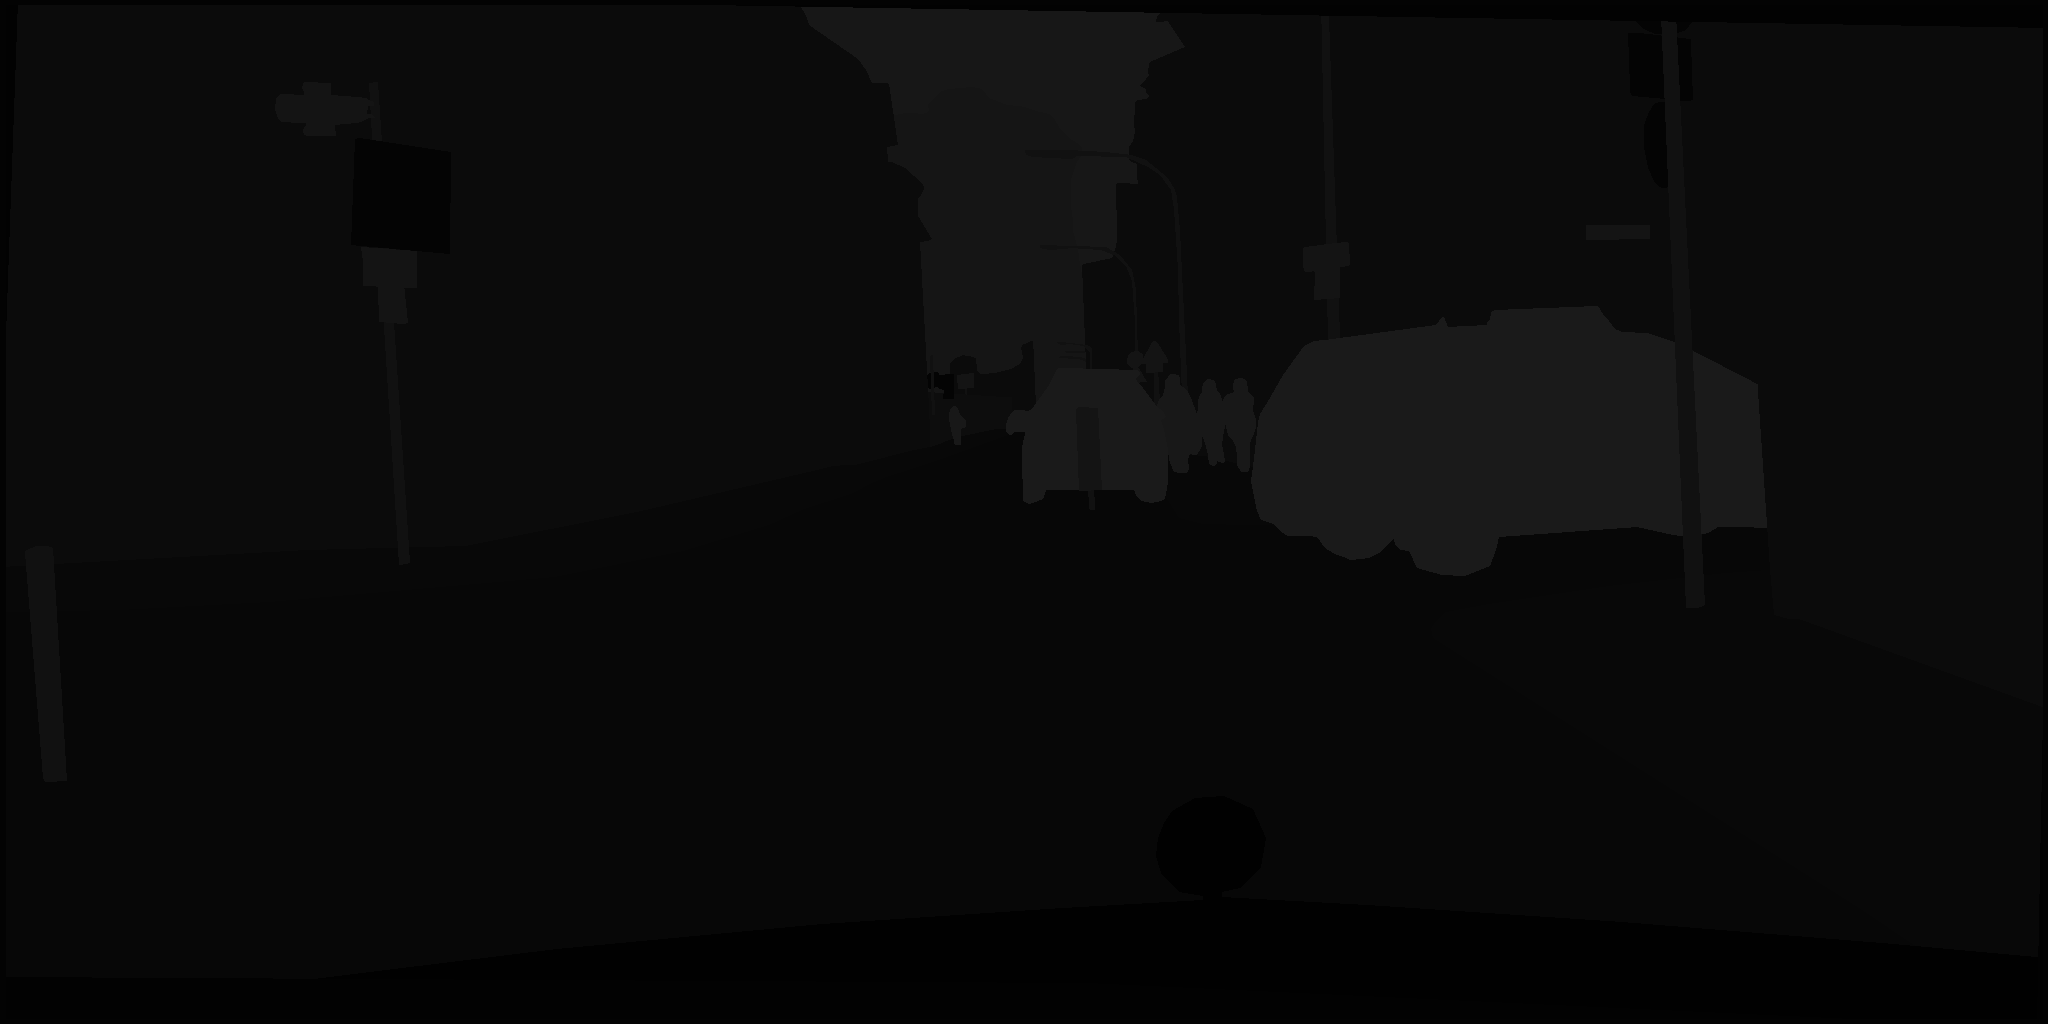

In [12]:
input_mask_path = "data/gtFine/val/frankfurt/"
# out_mask_put = "data/gtFine/val/frankfurt/mask.tiff"
# Filter the list to include only files with "color" in their name
color_png_files = [file for file in sorted(os.listdir(input_mask_path)) if 'label' in os.path.basename(file).lower()]
mask_images = []
for png_file in color_png_files[:2]:
    image = Image.open(os.path.join(input_mask_path, png_file))
    mask_images.append(image)
# images[0].save(out_mask_put, save_all=True, append_images=images[:2])
print(mask_images[0].size)
mask_images[0]

In [13]:
image_array = np.stack([np.array(image) for image in input_images])

image_array.shape

(2, 1024, 2048, 3)

In [14]:
mask_array = np.stack([np.array(image) for image in mask_images])
mask_array.shape
# plt.imshow(mask_array[..., -1])
# for i in range(mask_array.shape[-1]):
#     plt.imshow(mask_array[..., i], cmap='gray')
#     plt.show()

(2, 1024, 2048)

In [15]:
patch_size = 256
step = 256

In [16]:
all_img_patches = []
for img in range(image_array.shape[0]):
    large_image = image_array[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j]
            all_img_patches.append(single_patch_img)

images = np.squeeze(np.array(all_img_patches))

all_mask_patches = []
for img in range(mask_array.shape[0]):
    large_mask = mask_array[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask ).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [17]:
images.shape, masks.shape

((64, 256, 256, 3), (64, 256, 256))

In [18]:

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [19]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 64
})

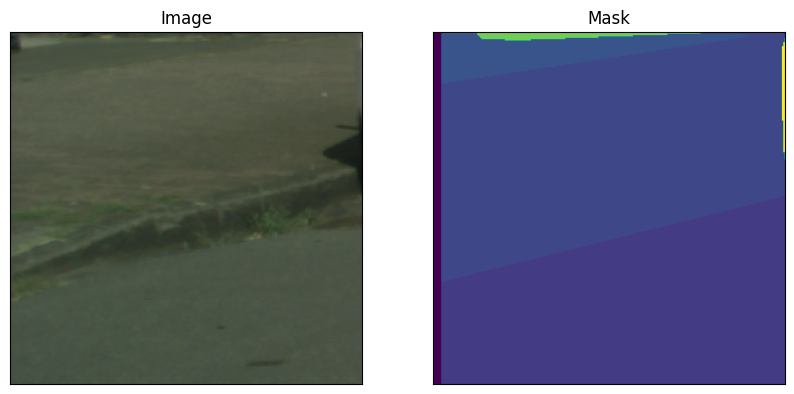

In [20]:
img_num = random.randint(0, images.shape[0] - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image (RGB) on the left
axes[0].imshow(np.array(example_image))
axes[0].set_title("Image")

# Plot the second image (RGB) on the right
axes[1].imshow(np.array(example_mask))
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [21]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox
     

In [22]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [23]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [24]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [25]:
# example = train_dataset[0]
# for k,v in example.items():
#   print(k,v.shape)

In [26]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [27]:
# batch = next(iter(train_dataloader))
# with open("output.txt", "w") as text_file:
#     for k, v in batch.items():
#         output = f"{k} {v.shape}\n{v}\n\n"
#         text_file.write(output)

In [28]:
# batched_input = []
# for i in range(1):  # Assuming you have 2 images in the batch
#     image_dict = {
#         'image': example['pixel_values'][i],
#         'original_size': example['original_sizes'][i],
#         'reshaped_input_sizes': example['reshaped_input_sizes'][i],
#         'input_boxes': example['input_boxes'][i],
#         'ground_truth_mask': example['ground_truth_mask'][i]
#     }
#     batched_input.append(image_dict)

In [29]:
# batched_input

In [30]:
# batch["ground_truth_mask"].shape

In [31]:
# Load the model
model = sam

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("image_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [32]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [33]:
# print(torch.stack([o["masks"] for o in outputs]).shape)

In [39]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# for i in range(len(batched_input)):
#     for key, value in batched_input[i].items():
#         if isinstance(value, torch.Tensor):
#             batched_input[i][key] = value.to(device)
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        batched_input = []
        for i in range(len(batch['pixel_values'])):
            batched_input.append({
                'image': batch['pixel_values'][i],
                'original_size': batch['original_sizes'][i],
                # 'reshaped_input_sizes': batch['reshaped_input_sizes'][i],
                'boxes': batch['input_boxes'][i],
                'mask_inputs': batch['ground_truth_mask'][i]
            })

        # forward pass
        outputs = model(batched_input = batched_input,
                        multimask_output=False)
        # dict_iterator = iter(output.items())
        # predicted_masks = next(dict_iterator)[1]
        predicted_masks = [o["masks"] for o in outputs]
        print(predicted_masks.squeeze(1).shape)
        # print(predicted_masks[1].shape)
        # compute loss
        # predicted_masks = outputs[].unsqueeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        print(ground_truth_masks.shape)
        # loss = seg_loss(predicted_masks, ground_truth_masks.squeeze(1))

    #   # backward pass (compute gradients of parameters w.r.t. loss)
    #   optimizer.zero_grad()
    #   loss.backward()

    #   # optimize
    #   optimizer.step()
    #   epoch_losses.append(loss.item())

    # print(f'EPOCH: {epoch}')
    # print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:09<?, ?it/s]


TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [Tensor, Tensor]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [ ]:

image_array = np.array(image)
image_array.shape
# all_img_patches = []
# patches_img = patchify(image_array, patch_size, step=step)  #Step=256 for 256 patches means no overlap
# patches_img.shape
# for i in range(patches_img.shape[0]):
#         for j in range(patches_img.shape[1]):

#             single_patch_img = patches_img[i,j,:,:]
#             all_img_patches.append(single_patch_img)

(1024, 2048, 3)

In [ ]:

city_classes = [
    'road', 'sidewalk', 'parking', 'rail track',
    'person', 'rider',
    'car', 'truck', 'bus', 'on rails', 'motorcycle', 'bicycle', 'caravan', 'trailer',
    'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel',
    'pole', 'pole group', 'traffic sign', 'traffic light',
    'vegetation', 'terrain',
    'sky',
    'ground', 'dynamic', 'static'
]

In [ ]:
import clip
import os
from tqdm.auto import tqdm
from PIL import Image

def generate_text_embeddings(classnames, templates, model):
    with torch.no_grad():
        class_embeddings_list = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).to(device) #tokenize
            class_embedding = model.encode_text(texts) #embed with text encoder
            class_embeddings_list.append(class_embedding)
        class_embeddings = torch.stack(class_embeddings_list, dim=1).to(device)
    return class_embeddings

## clip
def predict(mask_generator):
    clip_model, preprocess = clip.load("ViT-B/16", device=device)
    text_features = generate_text_embeddings(city_classes, ['a clean origami {}.'], clip_model)#['a rendering of a weird {}.'], model)

    targets = ["../data/leftImg8bit/val/frankfurt/frankfurt_000000_002196_leftImg8bit.png"]
    
    for t in tqdm(targets):
        image = np.array(Image.open(t))
        if image is None:
            print(f"Could not load '{t}' as an image, skipping...")
            continue

        masks = mask_generator.generate(image)
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        show_anns(masks)
        plt.axis('off')
        plt.show() 
        
        clip_model.eval()
        for i in range(len(masks)):
            mask = masks[i]["segmentation"]
            image_new = image.copy()
            ind = np.where(mask > 0)
            image_new[mask == 0] = 0
            y1, x1, y2, x2 = min(ind[0]), min(ind[1]), max(ind[0]), max(ind[1])
            image_new = Image.fromarray(image_new[y1:y2+1, x1:x2+1])
            plt.imshow(image_new)
            plt.show()
            image_new = preprocess(image_new)
            # plt.imshow(image_new.permute(1, 2, 0))
            image_features = clip_model.encode_image(image_new.unsqueeze(0).to(device))
            # Pick the top 5 most similar labels for the image
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.squeeze(0)
            similarity = (100.0 * image_features.float() @ text_features.float().T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)

            print("\nTop predictions for i-th mask:\n")
            for value, index in zip(values, indices):
                print(f"{city_classes[index]:>16s}: {100 * value.item():.2f}%")
            del image_new  # Release image variables
            torch.cuda.empty_cache()  # Empty GPU memory
    print("Done!")

  0%|          | 0/1 [00:00<?, ?it/s]

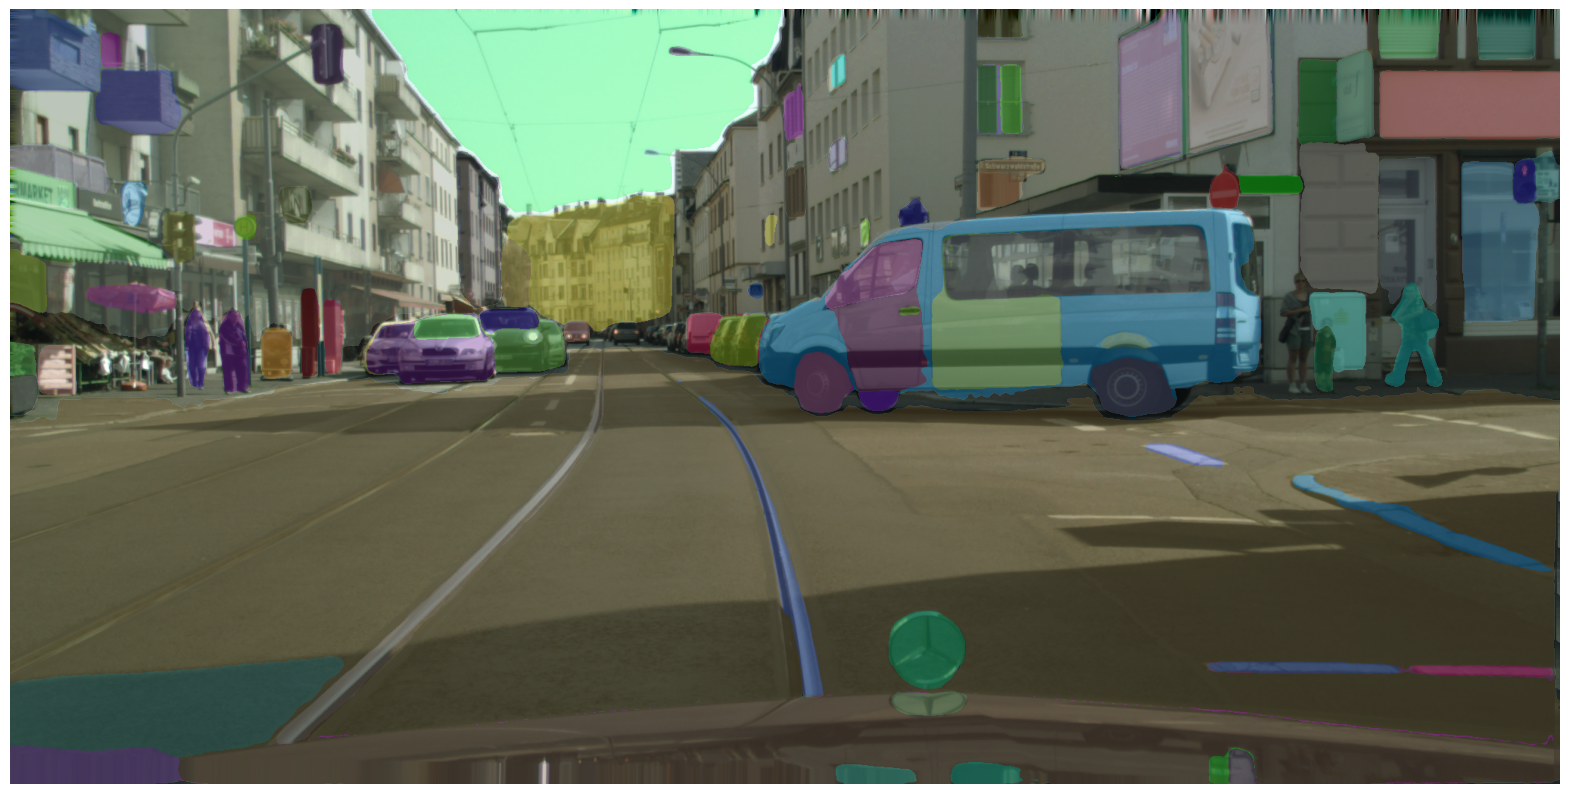

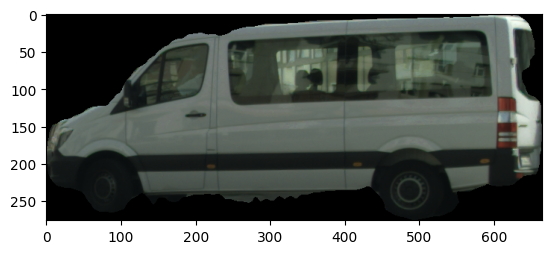


Top predictions for i-th mask:

             bus: 74.82%
           truck: 10.69%
         caravan: 5.44%
             car: 4.59%
         trailer: 2.15%


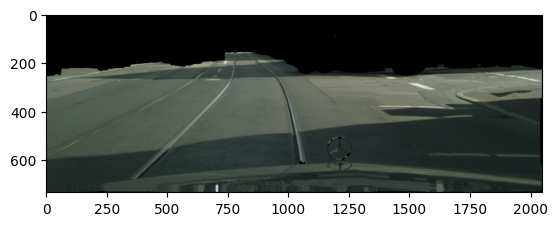


Top predictions for i-th mask:

      rail track: 27.63%
      guard rail: 14.06%
        on rails: 12.72%
            road: 12.55%
         parking: 11.91%


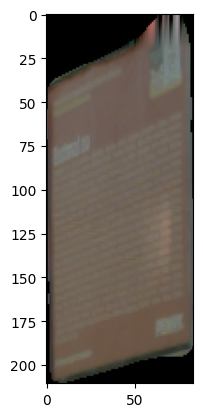


Top predictions for i-th mask:

            wall: 37.98%
      guard rail: 13.90%
           fence: 9.46%
            pole: 7.72%
          static: 4.14%


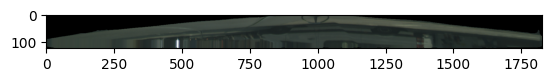


Top predictions for i-th mask:

      rail track: 18.07%
      guard rail: 10.60%
         trailer: 9.29%
          static: 7.19%
        on rails: 5.06%


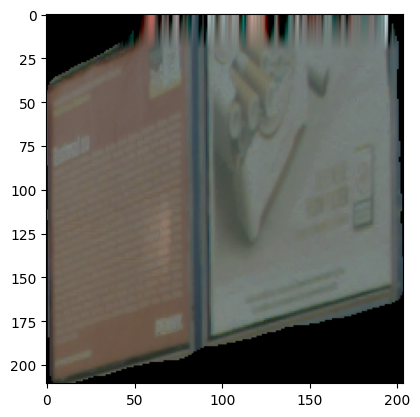


Top predictions for i-th mask:

         trailer: 26.52%
          static: 13.97%
      guard rail: 13.74%
        on rails: 7.62%
           rider: 4.88%


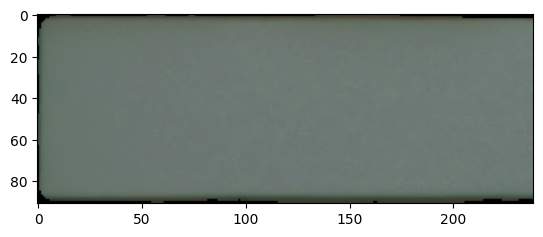


Top predictions for i-th mask:

          static: 18.99%
      guard rail: 16.97%
      rail track: 7.94%
            pole: 7.64%
          ground: 5.58%


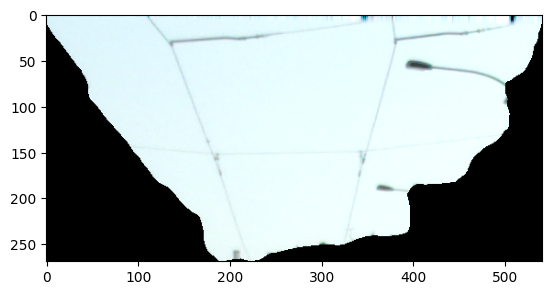


Top predictions for i-th mask:

         trailer: 16.04%
            pole: 15.63%
          static: 15.34%
      pole group: 10.74%
           rider: 5.16%


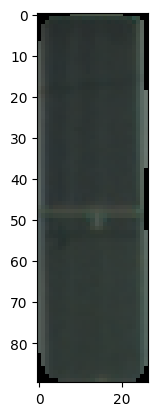


Top predictions for i-th mask:

      guard rail: 26.17%
        on rails: 8.80%
          static: 8.04%
            pole: 7.99%
          ground: 5.96%


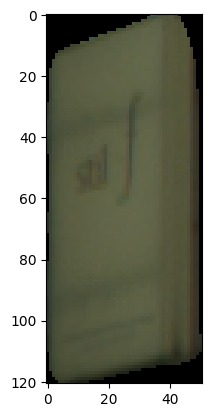


Top predictions for i-th mask:

      guard rail: 25.59%
            pole: 19.73%
            wall: 7.90%
          static: 6.75%
        on rails: 6.01%


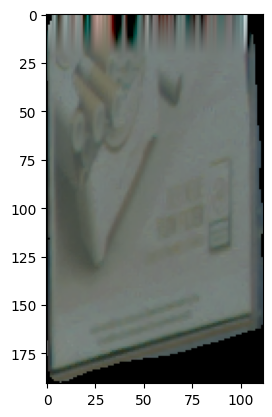


Top predictions for i-th mask:

         trailer: 18.35%
          static: 14.80%
          person: 11.19%
      guard rail: 10.03%
           rider: 7.10%


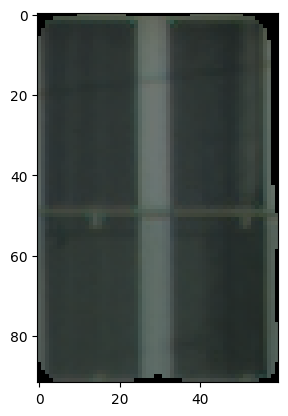


Top predictions for i-th mask:

            pole: 34.27%
      guard rail: 21.96%
          static: 11.96%
      pole group: 5.60%
      rail track: 2.95%


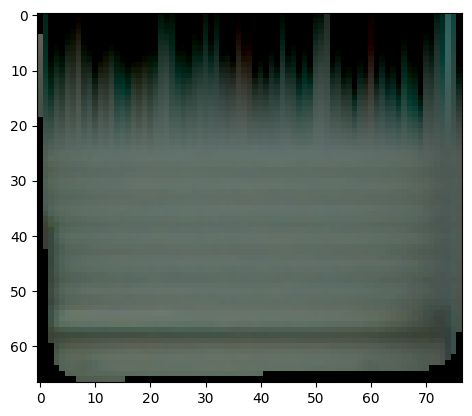


Top predictions for i-th mask:

          static: 31.37%
        on rails: 27.46%
      rail track: 10.90%
         trailer: 4.82%
         terrain: 3.78%


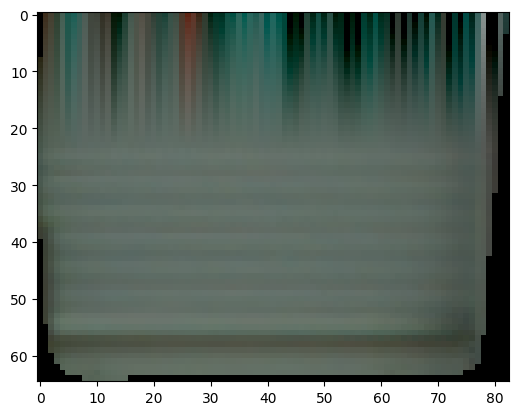


Top predictions for i-th mask:

          static: 28.83%
        on rails: 20.20%
         trailer: 16.12%
      rail track: 10.80%
         dynamic: 2.83%


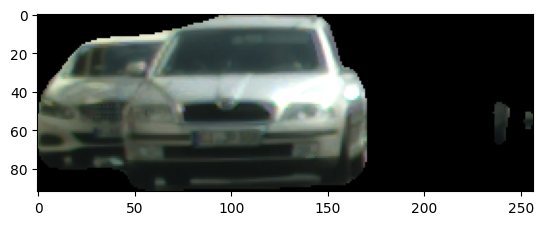


Top predictions for i-th mask:

             car: 72.35%
         parking: 6.03%
      guard rail: 5.27%
          static: 3.82%
         trailer: 3.71%


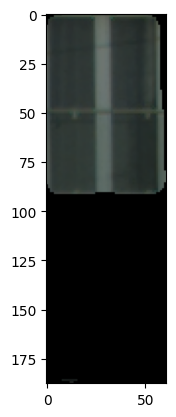


Top predictions for i-th mask:

            pole: 16.23%
          static: 16.06%
      guard rail: 14.89%
      rail track: 7.48%
        on rails: 6.85%


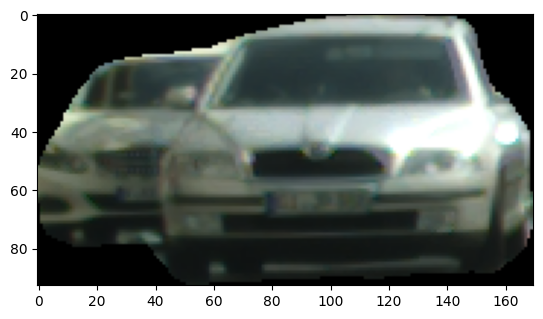


Top predictions for i-th mask:

             car: 74.18%
         parking: 8.12%
      guard rail: 3.50%
         trailer: 3.24%
          static: 2.65%


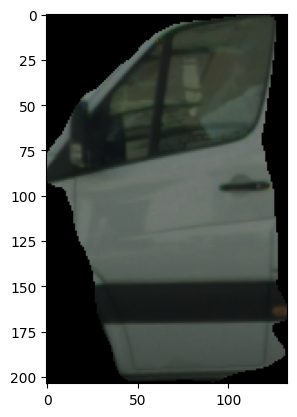


Top predictions for i-th mask:

             car: 39.38%
           truck: 25.38%
             bus: 8.33%
         parking: 8.24%
         trailer: 6.33%


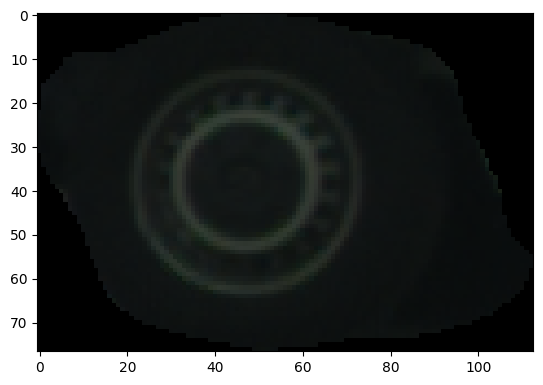


Top predictions for i-th mask:

          static: 32.11%
         trailer: 21.78%
      rail track: 10.87%
        on rails: 8.08%
         dynamic: 3.74%


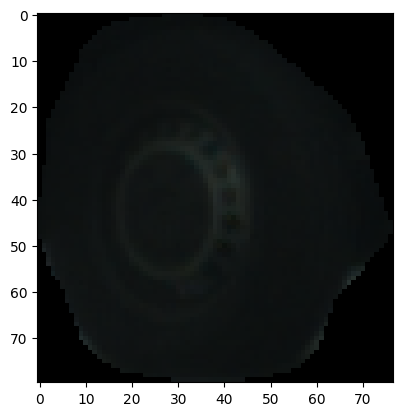


Top predictions for i-th mask:

        on rails: 14.62%
          static: 13.16%
         trailer: 11.97%
             car: 8.02%
      rail track: 6.87%


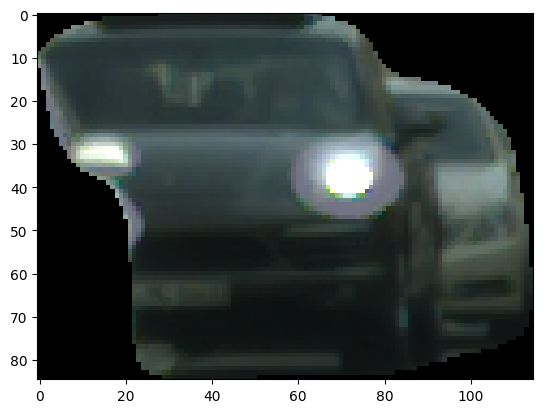


Top predictions for i-th mask:

             car: 51.16%
         trailer: 19.11%
         parking: 7.26%
      guard rail: 5.35%
          static: 3.21%


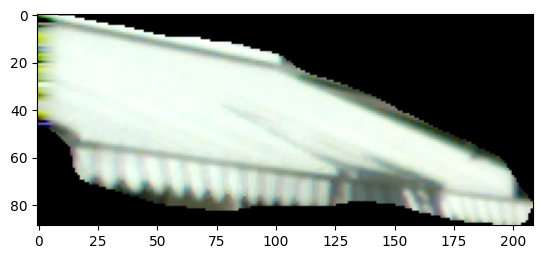


Top predictions for i-th mask:

      rail track: 35.58%
         caravan: 8.62%
      guard rail: 8.39%
            pole: 6.17%
          bridge: 5.73%


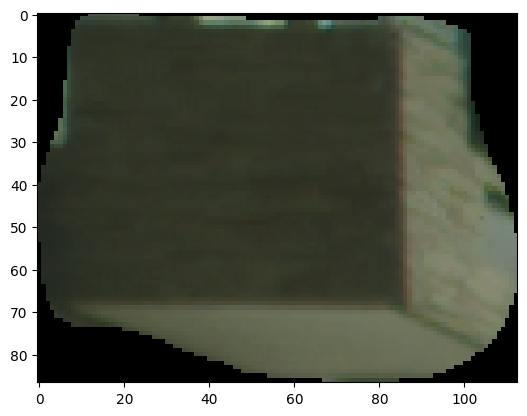


Top predictions for i-th mask:

         trailer: 13.40%
      rail track: 10.80%
          static: 10.62%
         terrain: 9.85%
      guard rail: 8.77%


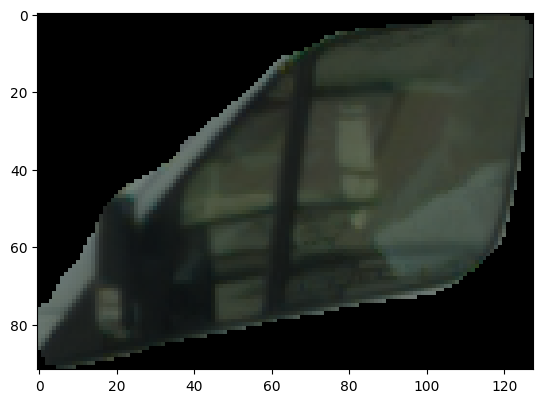


Top predictions for i-th mask:

             car: 61.42%
         trailer: 7.87%
             bus: 5.73%
           truck: 5.66%
         parking: 4.93%


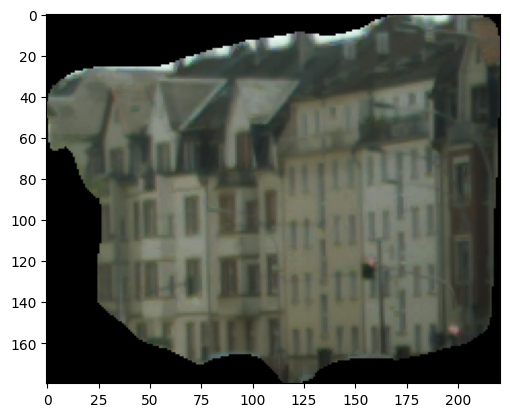


Top predictions for i-th mask:

         terrain: 20.33%
        on rails: 17.91%
         trailer: 7.34%
        building: 6.84%
      guard rail: 6.59%


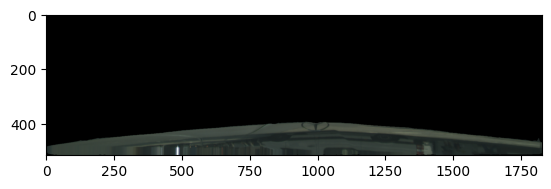


Top predictions for i-th mask:

         terrain: 13.49%
         trailer: 12.41%
         caravan: 6.66%
             bus: 6.23%
      vegetation: 6.02%


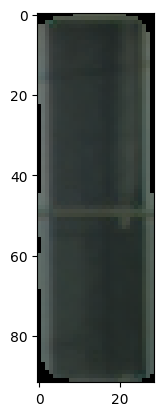


Top predictions for i-th mask:

            pole: 58.71%
      guard rail: 22.11%
      pole group: 4.59%
      vegetation: 2.41%
      rail track: 2.12%


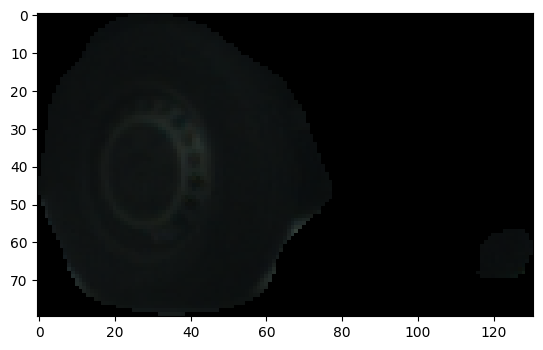


Top predictions for i-th mask:

         trailer: 13.65%
             car: 12.04%
      rail track: 7.37%
        on rails: 7.34%
           truck: 7.32%


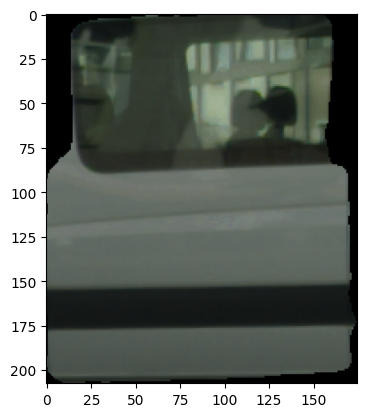


Top predictions for i-th mask:

          person: 19.74%
             bus: 11.49%
           rider: 11.10%
         caravan: 8.57%
      guard rail: 7.46%


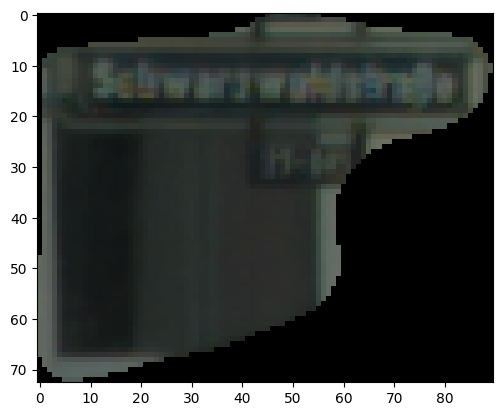


Top predictions for i-th mask:

         trailer: 35.12%
      guard rail: 13.46%
         caravan: 8.67%
          static: 6.64%
        on rails: 6.35%


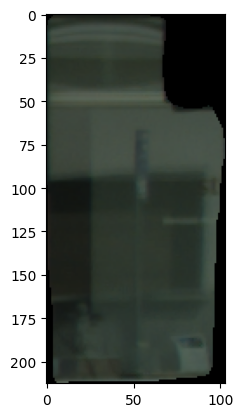


Top predictions for i-th mask:

            pole: 18.25%
          static: 16.73%
      guard rail: 14.83%
         trailer: 11.38%
      pole group: 5.07%


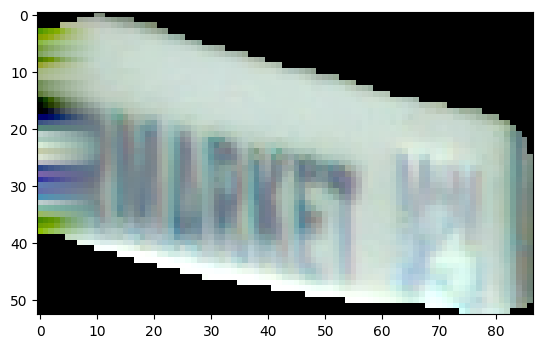


Top predictions for i-th mask:

      guard rail: 24.25%
            pole: 21.98%
      rail track: 12.11%
          static: 7.24%
    traffic sign: 6.09%


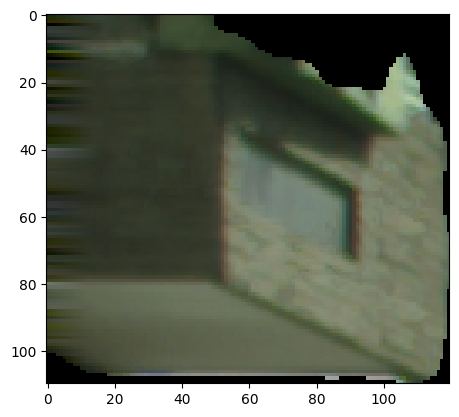


Top predictions for i-th mask:

         trailer: 15.39%
      rail track: 14.83%
      guard rail: 13.47%
         terrain: 10.67%
          static: 9.74%


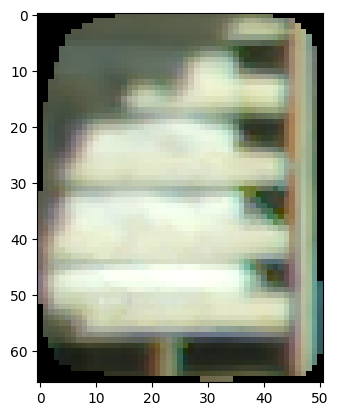


Top predictions for i-th mask:

      guard rail: 22.76%
          static: 17.82%
        on rails: 11.07%
      rail track: 10.08%
            pole: 9.59%


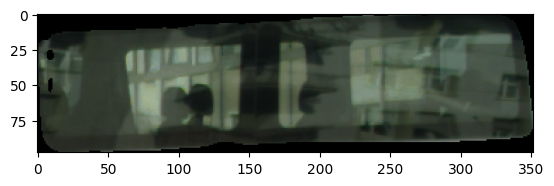


Top predictions for i-th mask:

             bus: 13.39%
         trailer: 12.34%
          static: 9.19%
      rail track: 8.85%
         caravan: 7.52%


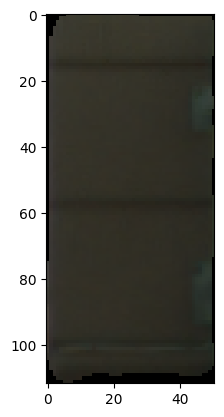


Top predictions for i-th mask:

      guard rail: 13.81%
      vegetation: 12.13%
            pole: 10.96%
          static: 9.57%
      rail track: 8.79%


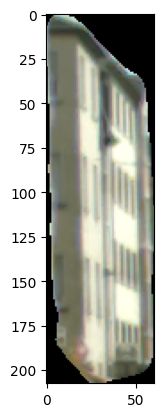


Top predictions for i-th mask:

          static: 27.70%
            pole: 10.03%
      guard rail: 8.75%
   traffic light: 6.36%
         trailer: 6.15%


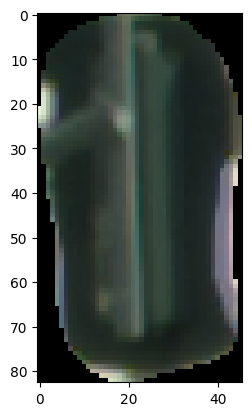


Top predictions for i-th mask:

            pole: 61.15%
      pole group: 8.30%
      guard rail: 7.65%
      vegetation: 4.62%
          person: 3.04%


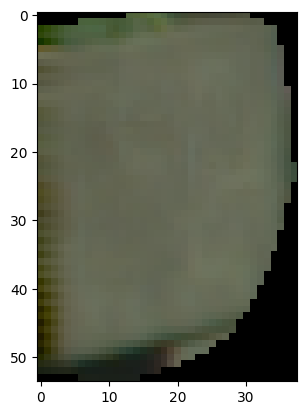


Top predictions for i-th mask:

      vegetation: 22.90%
          static: 22.48%
            pole: 12.16%
          person: 6.55%
      rail track: 3.56%


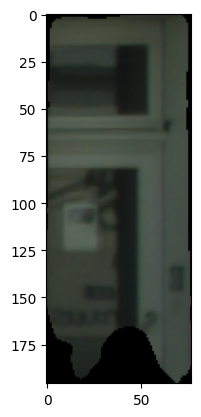


Top predictions for i-th mask:

      guard rail: 34.59%
            pole: 12.80%
        on rails: 6.03%
          static: 5.74%
            wall: 5.17%


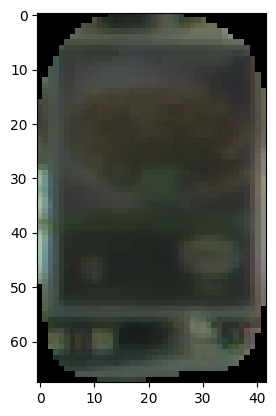


Top predictions for i-th mask:

      vegetation: 62.40%
          static: 10.09%
         terrain: 8.51%
          ground: 2.88%
         trailer: 2.27%


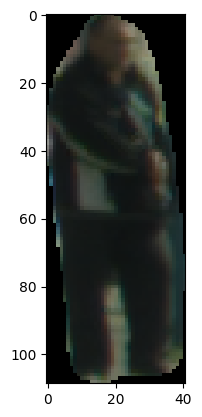


Top predictions for i-th mask:

           rider: 22.70%
          person: 20.49%
          static: 16.65%
            pole: 14.77%
      guard rail: 4.26%


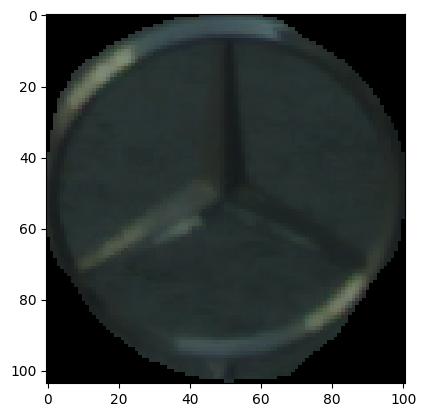


Top predictions for i-th mask:

          static: 22.82%
            pole: 15.95%
      guard rail: 15.64%
          ground: 5.91%
        on rails: 4.89%


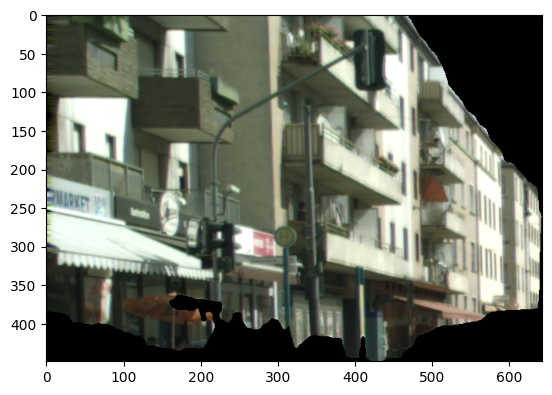


Top predictions for i-th mask:

        building: 23.80%
        on rails: 12.97%
         parking: 7.51%
         terrain: 7.06%
      guard rail: 6.86%


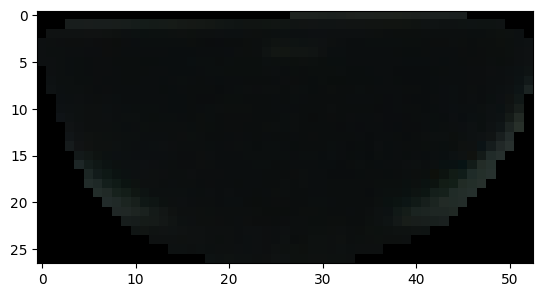


Top predictions for i-th mask:

         trailer: 26.47%
          static: 14.99%
      vegetation: 7.52%
          ground: 5.79%
      rail track: 4.72%


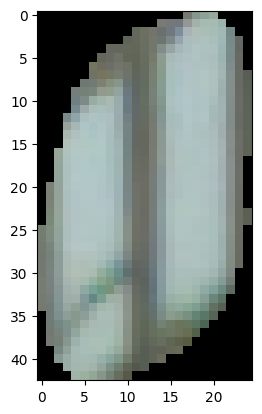


Top predictions for i-th mask:

            pole: 65.61%
      guard rail: 9.19%
          static: 5.08%
   traffic light: 4.62%
      pole group: 3.23%


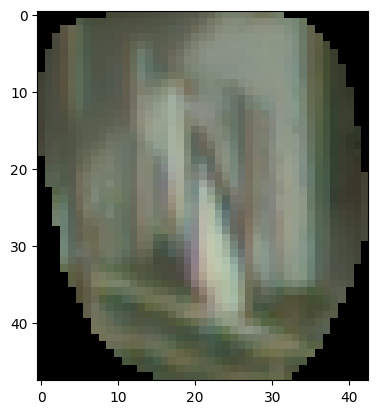


Top predictions for i-th mask:

          static: 33.95%
        on rails: 13.17%
      vegetation: 11.00%
         terrain: 6.60%
            pole: 5.77%


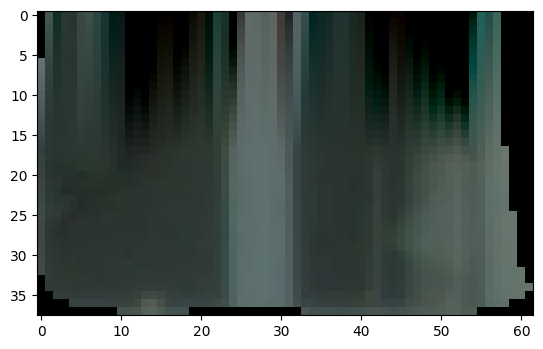


Top predictions for i-th mask:

          static: 28.78%
      vegetation: 16.77%
        on rails: 7.82%
         terrain: 7.54%
      guard rail: 5.61%


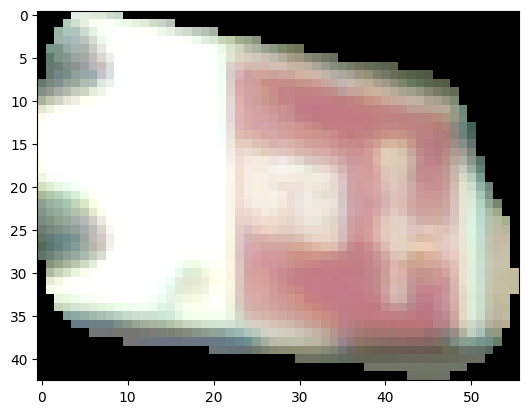


Top predictions for i-th mask:

      guard rail: 16.29%
        on rails: 13.83%
         trailer: 9.42%
      rail track: 7.86%
            pole: 6.91%


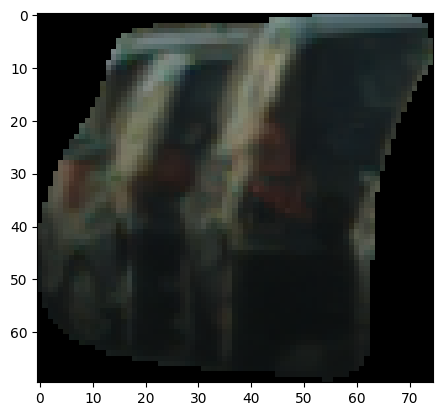


Top predictions for i-th mask:

         trailer: 17.06%
      guard rail: 12.63%
        on rails: 9.75%
           rider: 9.72%
          static: 9.54%


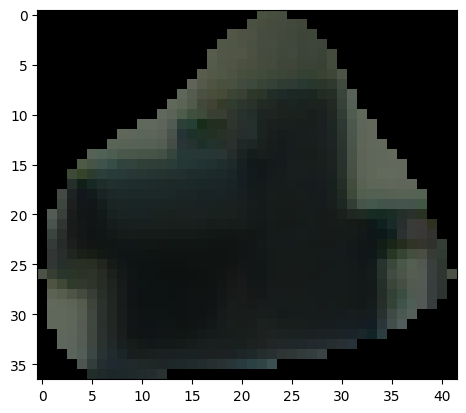


Top predictions for i-th mask:

      vegetation: 36.38%
          static: 19.13%
         trailer: 7.24%
          person: 6.14%
          ground: 5.90%


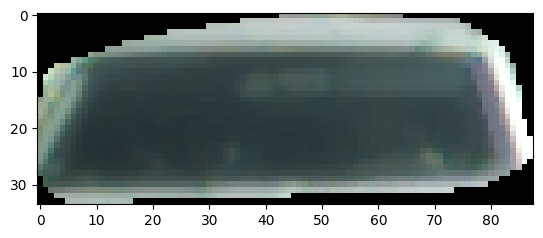


Top predictions for i-th mask:

      guard rail: 50.46%
            pole: 15.24%
      rail track: 15.03%
          static: 6.65%
        on rails: 2.82%


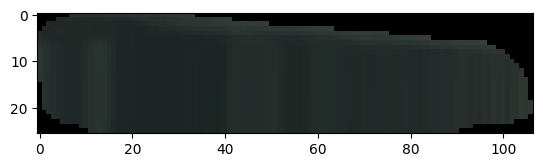


Top predictions for i-th mask:

        on rails: 14.98%
      rail track: 9.81%
      vegetation: 9.76%
         trailer: 8.66%
      guard rail: 8.36%


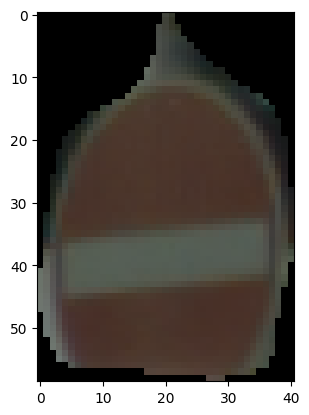


Top predictions for i-th mask:

            pole: 14.19%
    traffic sign: 11.27%
        on rails: 9.63%
   traffic light: 8.57%
      guard rail: 8.13%


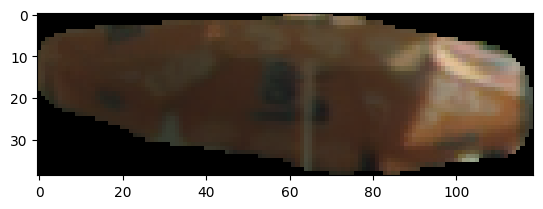


Top predictions for i-th mask:

         trailer: 19.17%
         caravan: 16.55%
         terrain: 7.68%
      guard rail: 7.47%
      rail track: 7.03%


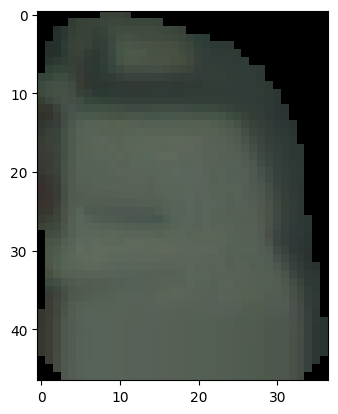


Top predictions for i-th mask:

            pole: 18.14%
          static: 17.85%
      vegetation: 10.70%
          person: 9.73%
      guard rail: 8.50%


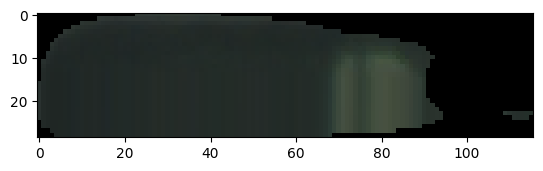


Top predictions for i-th mask:

      vegetation: 16.53%
         trailer: 10.82%
        on rails: 8.65%
          static: 8.45%
          ground: 7.08%


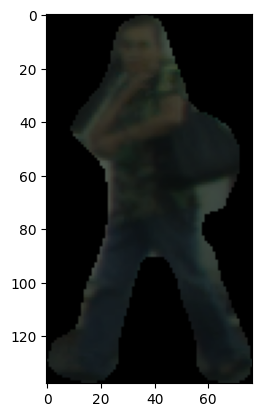


Top predictions for i-th mask:

          person: 28.54%
           rider: 26.02%
          static: 21.41%
        on rails: 4.22%
         trailer: 3.65%


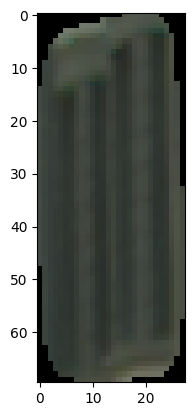


Top predictions for i-th mask:

      guard rail: 16.75%
            pole: 13.86%
      vegetation: 13.46%
          static: 11.98%
        on rails: 7.11%


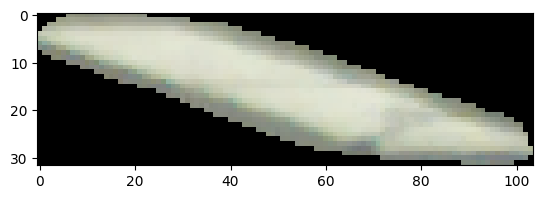


Top predictions for i-th mask:

      guard rail: 17.62%
          static: 17.34%
            pole: 17.08%
      rail track: 10.62%
        on rails: 8.95%


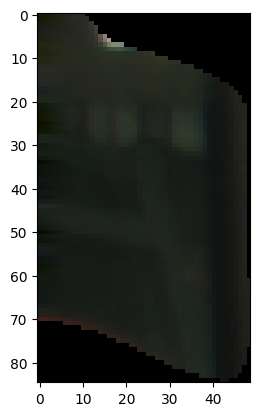


Top predictions for i-th mask:

          static: 15.03%
      vegetation: 13.61%
         trailer: 12.89%
      guard rail: 10.89%
        on rails: 7.78%


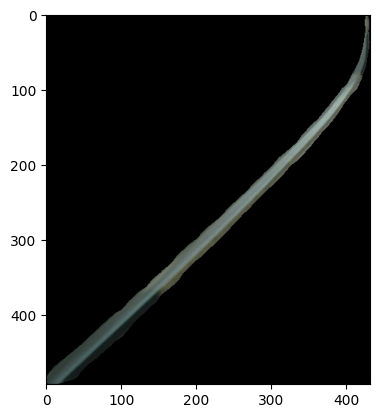


Top predictions for i-th mask:

      rail track: 51.04%
      guard rail: 10.51%
         trailer: 8.10%
        on rails: 6.26%
            pole: 5.71%


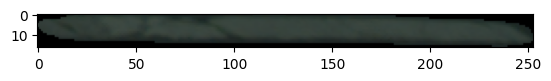


Top predictions for i-th mask:

      guard rail: 15.12%
         trailer: 14.89%
      vegetation: 11.95%
      rail track: 9.26%
        on rails: 7.52%


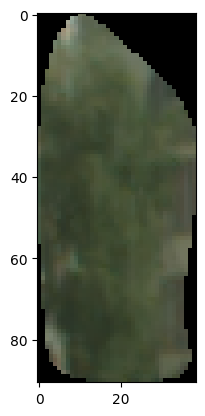


Top predictions for i-th mask:

      vegetation: 65.09%
          static: 7.30%
         terrain: 5.14%
            pole: 4.52%
          ground: 3.30%


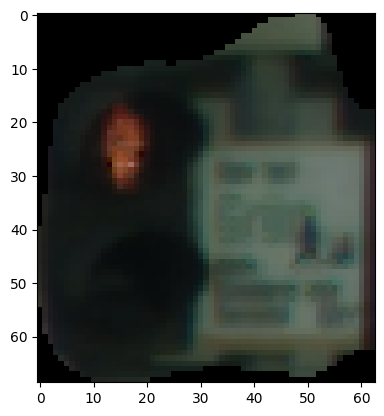


Top predictions for i-th mask:

    traffic sign: 67.00%
   traffic light: 31.65%
      guard rail: 0.37%
            pole: 0.18%
            road: 0.12%


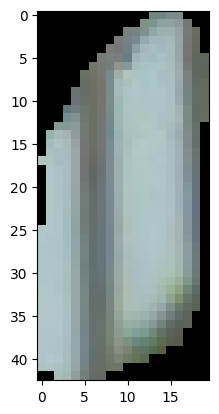


Top predictions for i-th mask:

      guard rail: 17.56%
          static: 15.32%
            pole: 12.48%
         trailer: 8.48%
        on rails: 7.82%


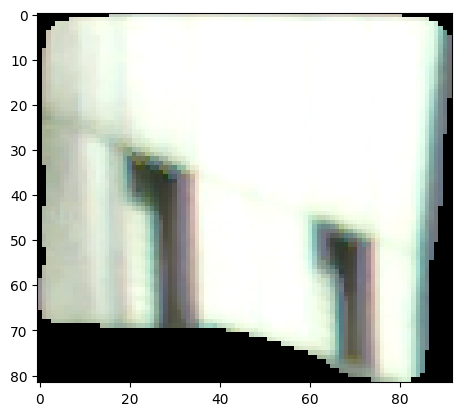


Top predictions for i-th mask:

      guard rail: 18.19%
          static: 15.71%
        on rails: 14.86%
      rail track: 8.58%
         trailer: 7.23%


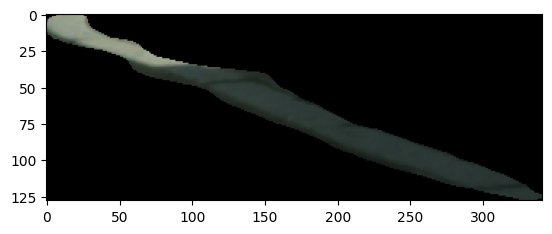


Top predictions for i-th mask:

      guard rail: 27.09%
            pole: 23.54%
      rail track: 15.76%
      vegetation: 9.32%
        on rails: 4.80%


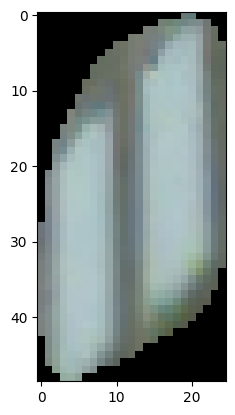


Top predictions for i-th mask:

            pole: 50.57%
      guard rail: 13.27%
          static: 8.94%
      vegetation: 4.32%
      pole group: 3.65%


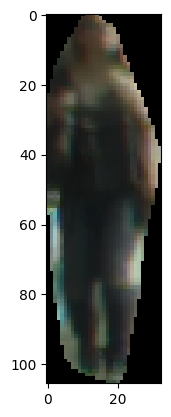


Top predictions for i-th mask:

            pole: 25.01%
          static: 19.51%
          person: 17.76%
           rider: 8.08%
      vegetation: 5.88%


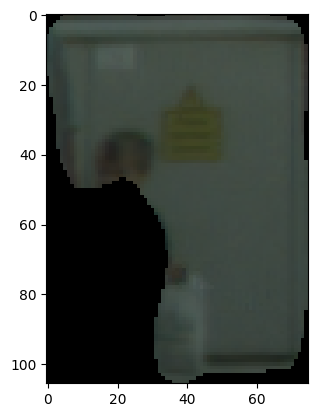


Top predictions for i-th mask:

    traffic sign: 22.83%
      guard rail: 17.07%
          person: 13.90%
          static: 5.99%
         trailer: 5.46%


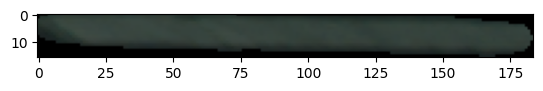


Top predictions for i-th mask:

      guard rail: 23.55%
        on rails: 10.22%
      vegetation: 9.25%
         trailer: 8.06%
      rail track: 7.43%


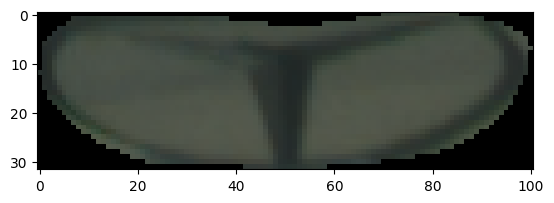


Top predictions for i-th mask:

      guard rail: 25.79%
      rail track: 10.75%
         trailer: 9.51%
            pole: 7.96%
      vegetation: 6.62%


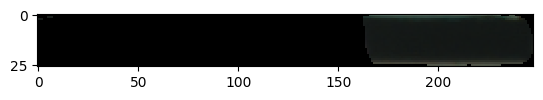


Top predictions for i-th mask:

         trailer: 16.87%
        on rails: 16.85%
      pole group: 12.68%
      rail track: 11.14%
          static: 9.45%


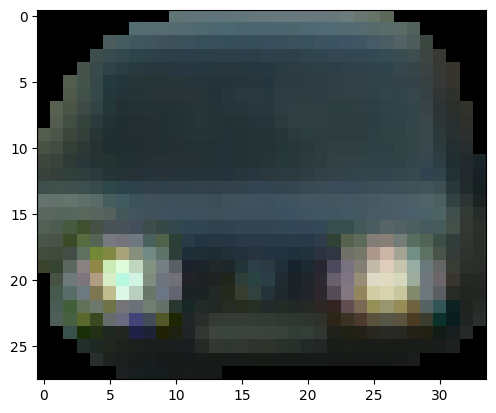


Top predictions for i-th mask:

             car: 56.55%
         trailer: 12.60%
           truck: 9.50%
         caravan: 5.63%
             bus: 4.27%


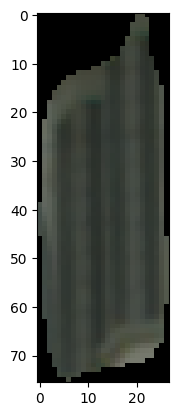


Top predictions for i-th mask:

            pole: 64.37%
      guard rail: 10.81%
      pole group: 7.13%
      vegetation: 4.28%
          static: 3.70%


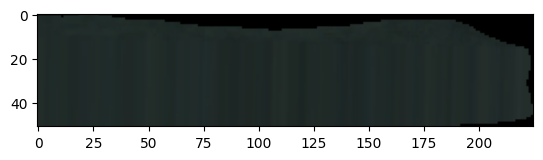


Top predictions for i-th mask:

        on rails: 27.07%
      vegetation: 8.56%
         trailer: 8.34%
      rail track: 6.19%
      pole group: 4.80%


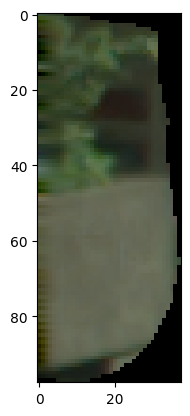


Top predictions for i-th mask:

      vegetation: 47.56%
            pole: 7.24%
      guard rail: 6.81%
          static: 4.97%
           fence: 4.22%


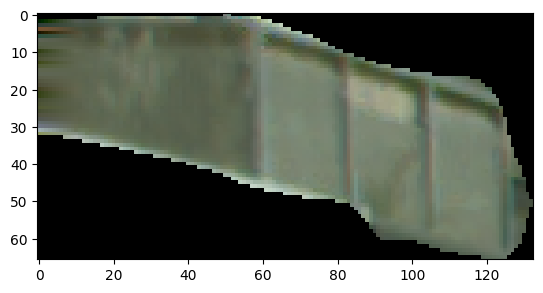


Top predictions for i-th mask:

      rail track: 27.12%
      guard rail: 20.58%
          static: 11.54%
        on rails: 8.25%
      vegetation: 6.62%


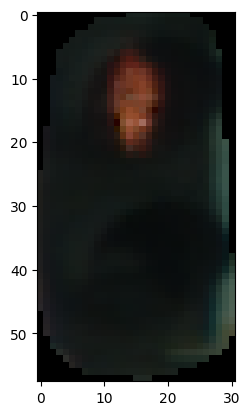


Top predictions for i-th mask:

            pole: 19.28%
      vegetation: 16.58%
          person: 14.34%
          static: 13.32%
           rider: 6.15%


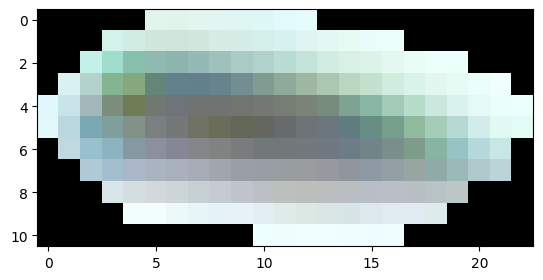


Top predictions for i-th mask:

          static: 49.92%
        on rails: 14.23%
             sky: 7.82%
      vegetation: 6.96%
            pole: 4.11%


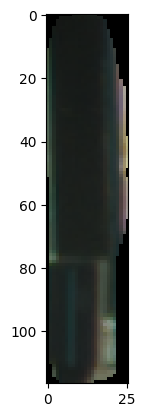


Top predictions for i-th mask:

            pole: 34.34%
      guard rail: 17.29%
          static: 6.92%
      vegetation: 5.75%
      pole group: 4.80%


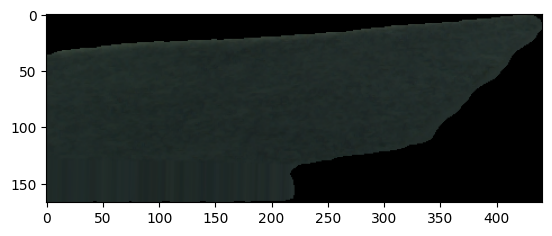


Top predictions for i-th mask:

      guard rail: 34.12%
      rail track: 14.24%
        on rails: 9.38%
      vegetation: 7.08%
          static: 6.42%


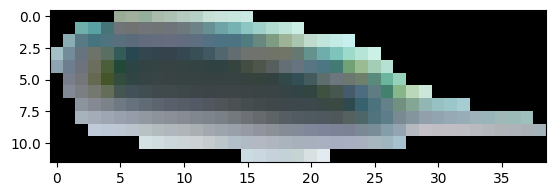


Top predictions for i-th mask:

          static: 20.86%
      guard rail: 14.53%
        on rails: 12.18%
            pole: 9.06%
         trailer: 9.03%


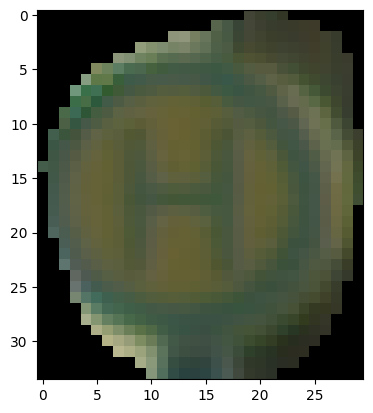


Top predictions for i-th mask:

        on rails: 29.03%
      vegetation: 12.19%
          ground: 8.82%
          static: 8.79%
            pole: 6.05%


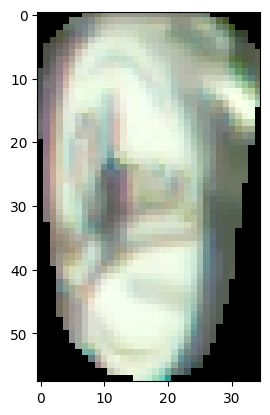


Top predictions for i-th mask:

          person: 37.55%
          static: 24.07%
            pole: 9.03%
           rider: 7.33%
      pole group: 3.99%


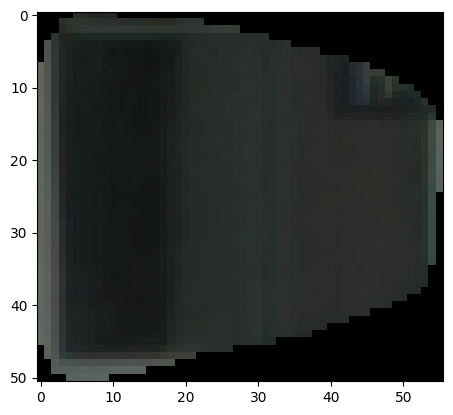


Top predictions for i-th mask:

      guard rail: 22.00%
            pole: 18.83%
          static: 12.13%
      rail track: 7.64%
         trailer: 5.82%


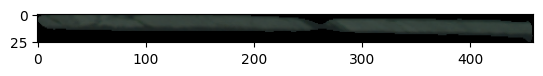


Top predictions for i-th mask:

      guard rail: 22.32%
      rail track: 16.77%
        on rails: 13.59%
      vegetation: 9.72%
         trailer: 6.74%


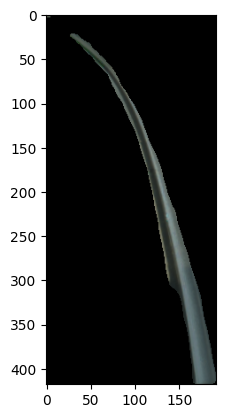


Top predictions for i-th mask:

            pole: 52.62%
      guard rail: 17.59%
      rail track: 8.28%
         bicycle: 3.45%
      vegetation: 3.26%


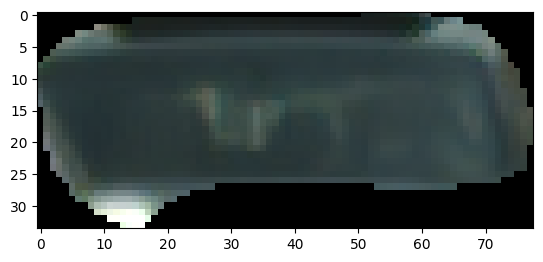


Top predictions for i-th mask:

      guard rail: 47.14%
      rail track: 14.51%
        on rails: 6.90%
          static: 5.21%
            pole: 5.09%


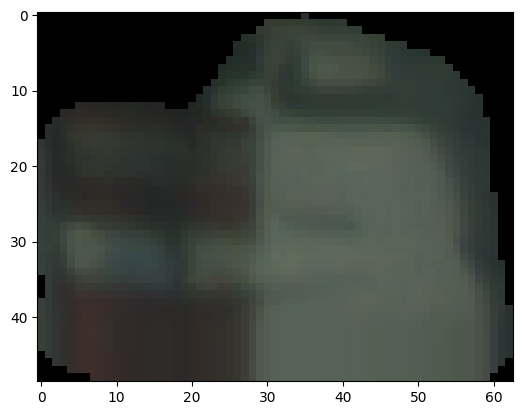


Top predictions for i-th mask:

         trailer: 14.47%
          static: 13.47%
        on rails: 9.34%
          person: 7.24%
         terrain: 5.49%


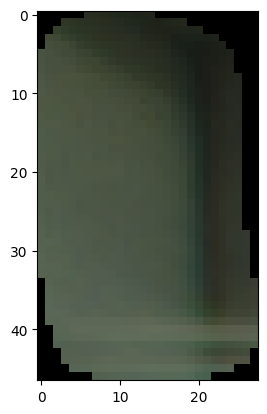


Top predictions for i-th mask:

      vegetation: 23.96%
          static: 13.94%
      guard rail: 9.96%
          ground: 9.22%
          person: 6.13%


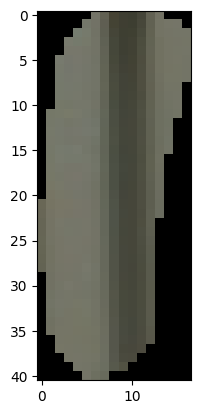


Top predictions for i-th mask:

            pole: 48.91%
      guard rail: 15.63%
      vegetation: 8.42%
          static: 5.66%
      pole group: 3.86%


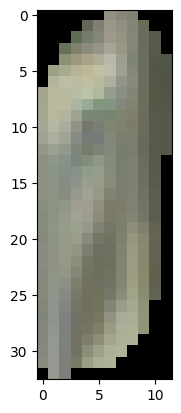


Top predictions for i-th mask:

         terrain: 24.62%
          static: 20.14%
      vegetation: 13.40%
        on rails: 11.86%
         trailer: 6.63%


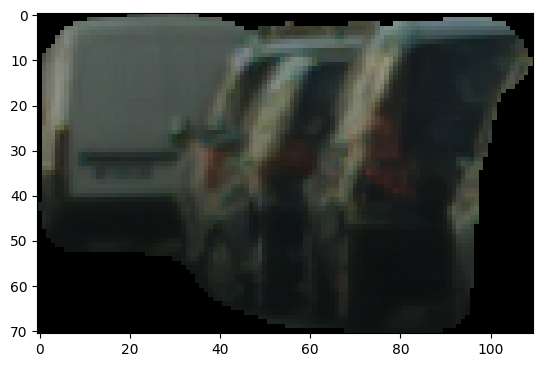


Top predictions for i-th mask:

           truck: 22.86%
         trailer: 16.65%
         caravan: 16.35%
         parking: 14.31%
             car: 13.90%


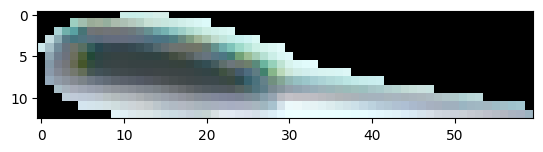


Top predictions for i-th mask:

      vegetation: 23.43%
        on rails: 21.03%
         terrain: 15.84%
          static: 8.16%
      rail track: 5.88%


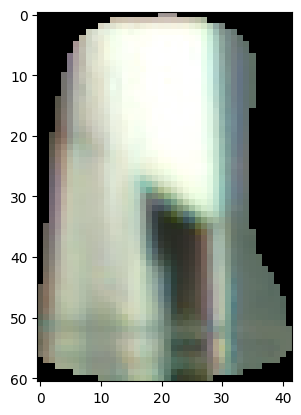


Top predictions for i-th mask:

            pole: 81.88%
      pole group: 5.58%
      guard rail: 3.20%
          static: 2.70%
          person: 1.14%


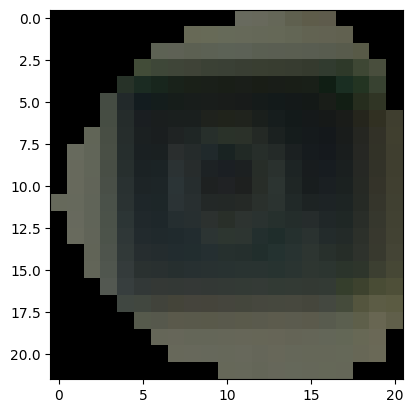


Top predictions for i-th mask:

          static: 22.69%
      vegetation: 18.46%
         trailer: 9.99%
            pole: 6.80%
        on rails: 6.14%


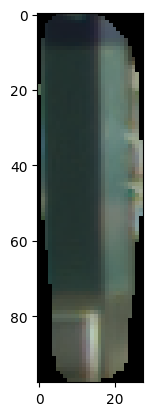


Top predictions for i-th mask:

            pole: 48.83%
      guard rail: 9.60%
   traffic light: 9.54%
      vegetation: 5.08%
          static: 5.06%


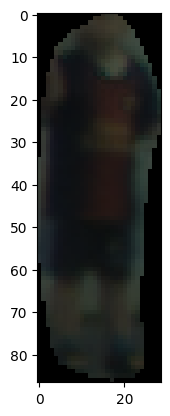


Top predictions for i-th mask:

            pole: 31.27%
      guard rail: 12.49%
          static: 11.08%
      vegetation: 6.44%
         trailer: 5.47%


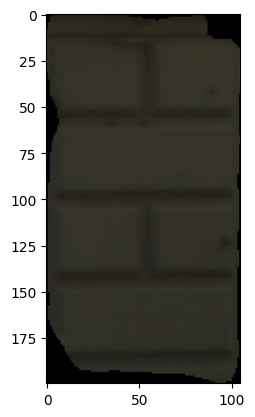


Top predictions for i-th mask:

      guard rail: 21.89%
      rail track: 13.09%
            wall: 12.82%
            pole: 10.04%
          static: 4.42%


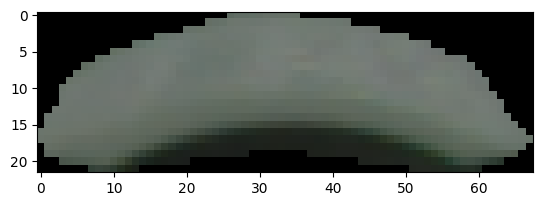


Top predictions for i-th mask:

      rail track: 18.80%
          static: 17.81%
      guard rail: 9.57%
         terrain: 8.78%
            pole: 7.25%


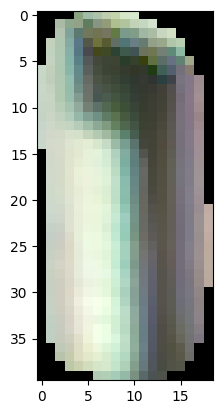


Top predictions for i-th mask:

            pole: 57.53%
      guard rail: 11.85%
          static: 9.83%
      vegetation: 4.53%
   traffic light: 4.02%


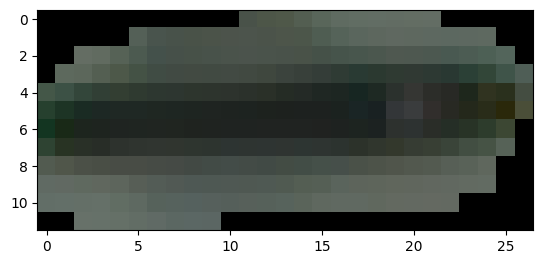


Top predictions for i-th mask:

      guard rail: 18.20%
          static: 17.49%
      rail track: 14.79%
            pole: 10.13%
         trailer: 8.10%


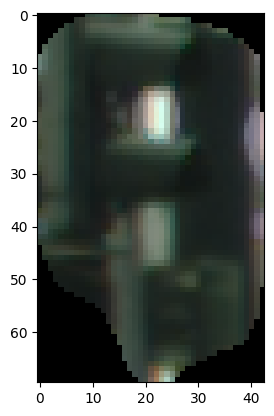


Top predictions for i-th mask:

            pole: 32.50%
          static: 16.55%
      guard rail: 8.52%
   traffic light: 8.12%
      vegetation: 5.98%
Done!


In [ ]:

with torch.no_grad():
        
    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side = 64,
        points_per_batch = 64,
        pred_iou_thresh = 0.88,
        stability_score_thresh = 0.95,
        stability_score_offset = 1.0,
        box_nms_thresh = 0.7,
        crop_n_layers = 0,
        crop_nms_thresh = 0.7,
        crop_overlap_ratio = 512 / 1500,
        crop_n_points_downscale_factor = 1,
        point_grids = None,
        min_mask_region_area = 0,
        output_mode = "binary_mask",
    )
    predict(mask_generator)